# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to build a model that identifies COVID-19, pneumonia in chest X-Ray images. The dataset is organized into 3 folders (COVID-19 cases, Normal , Pneumonia) and contains subfolders for each image category. There are 606 X-Ray images (JPEG). Data from [Mendeley](https://data.mendeley.com/datasets/fvk7h5dg2p/1). 

In [ ]:
import os
import time
import zipfile
from glob import glob

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from roboflow import Roboflow
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

Import API Keys needed

In [60]:
load_dotenv()
roboflow_api_key = os.getenv("ROBOFLOW_API_KEY")

## download and unzip images if not present

In [61]:
dataroot = "dataroot/"
zip_path = dataroot + "fvk7h5dg2p-1.zip"
raw_path = dataroot + "raw/"

def download_data(url):
    '''
    Creates a directory nammed 'dataroot' and downloads the zip file from the url and saves the zip file
    to the 'dataroot' folder.
    '''
    response = requests.get(url, params={"downloadformat": "zip"})
    if not os.path.isdir(dataroot):
        os.makedirs(dataroot)
        with open(zip_path, "wb") as file:
            file.write(response.content)


def unzip_data():
    if os.path.isdir(dataroot):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            for file in zip_ref.namelist():
                sanitized_name = file.strip().replace("\\", "/") #Ensure consistent path format
                #Sanitize folder name for "Normal "
                if sanitized_name.startswith("Normal "):
                    sanitized_name = sanitized_name.replace("Normal ", "Normal", 1)
                if sanitized_name.startswith("COVID-19"):
                    sanitized_name = sanitized_name.replace("COVID-19 cases", "COVID-19", 1)
            
                #Create the full target path within the 'Normal' folder
                target_path = os.path.join(raw_path, sanitized_name)

                #Skip directories (avoid trying to open them as files)
                if file.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                    continue
            
                #Ensure the parent directory exists before extracting
                os.makedirs(os.path.dirname(target_path), exist_ok=True)

                # Extract file safely
                with zip_ref.open(file) as source, open(target_path, "wb") as target:
                    target.write(source.read())

        os.remove(zip_path) # Remove zip file
        print("Extraction completed successfully.")

In [62]:
# Download and unzip
if not os.path.isdir(dataroot):
    download_data("https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip")
    unzip_data()
else:
    print("dataroot already exists.")

dataroot already exists.


## cleaning with roboflow

In [63]:
#Connecting to the model on roboflow
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace().project("cap-project-u384k")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


In order to work with roboflow api, had to resize large images so that they could be processed. Also, had to add some time.sleep() pauses to keep API calls from breaking.

In [ ]:
def resize_image(img, max_size=1024):
    """Function for resizing images for roboflow if they are too large for the api calls to handle"""
    height, width = img.shape[:2]
    if max(height, width) > max_size:
        scaling_factor = max_size / float(max(height, width))
        new_size = (int(width * scaling_factor), int(height * scaling_factor))
        img = cv.resize(img, new_size, interpolation=cv.INTER_AREA)
    return img

def safe_predict(model, img, retries=3):
    for attempt in range(retries):
        try:
            return model.predict(img, confidence=20, overlap=30).json()
        except requests.exceptions.ConnectionError as e:
            print(f"Connection error on attempt {attempt + 1}: {e}")
            time.sleep(2 ** attempt)  # exponential backoff
    raise RuntimeError("Max retries exceeded for model prediction.")

def clean_x_rays(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for item in os.walk(input_folder):
        root = item[0]
        files = item[2]
        for file in files:
            if not os.path.exists(os.path.join(output_folder, file)): # Skip over already processed files
                time.sleep(3)
                img = cv.imread(os.path.join(root, file))
                img = resize_image(img)
                result = safe_predict(model, img)
                for i in range(len(result['predictions'])):
                    prediction = result['predictions'][i]
                    roi_x = int(prediction['x'] - prediction['width']/2)
                    roi_y = int(prediction['y'] - prediction['height']/2)
                    roi_width = int(prediction['width'])
                    roi_height = int(prediction['height'])
                    img[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width] = 0
                cv.imwrite(os.path.join(output_folder, file), img)

If any of the cleaned image folders do not exist, then process all of the images. The cleaning process skips over images that already exist in the cleaned folder. 

In [65]:
raw_path = "dataroot/raw/"
clean_path = "dataroot/cleaned/"
if not all([os.path.isdir(clean_path + "COVID-19"),
            os.path.isdir(clean_path + "Normal"),
            os.path.isdir(clean_path + "Pneumonia")]):
    # Try up to 3 times since api sometimes has issues
    for attempt in range(3):
        clean_x_rays(raw_path + "COVID-19", clean_path + "COVID-19")
        clean_x_rays(raw_path + "Normal", clean_path + "Normal")
        clean_x_rays(raw_path + "Pneumonia", clean_path + "Pneumonia")

View raw images

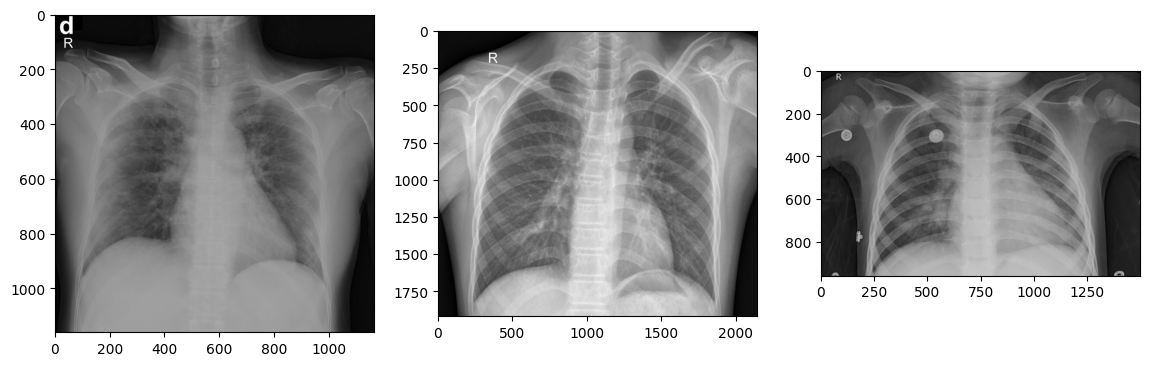

In [91]:
# Load and preview raw images
raw_img_covid     = cv.imread(raw_path + 'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0)
raw_img_normal    = cv.imread(raw_path + 'Normal/IM-0011-0001-0001.jpeg', 0)
raw_img_pneumonia = cv.imread(raw_path + 'Pneumonia/person11_virus_38.jpeg', 0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(raw_img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(raw_img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(raw_img_pneumonia,cmap='gray')

View Cleaned Images

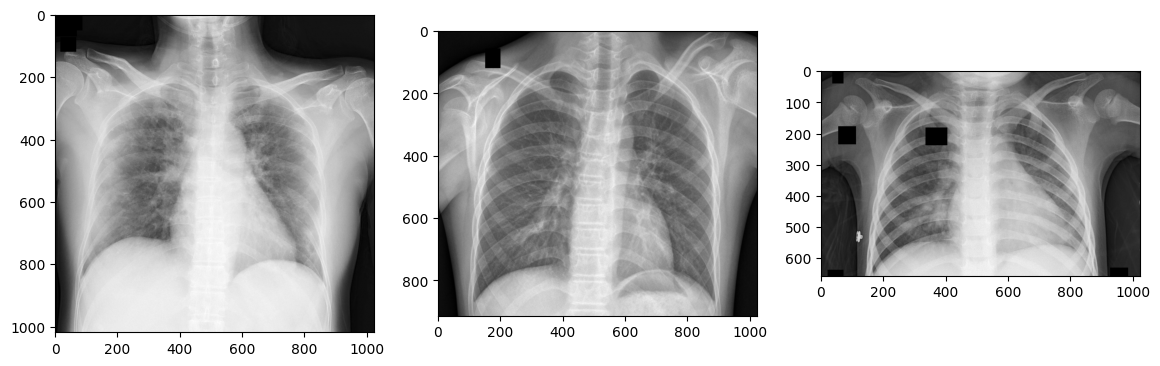

In [92]:

# Load and preview raw images
clean_img_covid     = cv.imread(clean_path + 'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0)
clean_img_normal    = cv.imread(clean_path + 'Normal/IM-0011-0001-0001.jpeg', 0)
clean_img_pneumonia = cv.imread(clean_path + 'Pneumonia/person11_virus_38.jpeg', 0)

plt.figure(figsize=(14,14))
plt.subplot(2,3,1)
plt.imshow(clean_img_covid,cmap='gray')
plt.subplot(2,3,2)
plt.imshow(clean_img_normal,cmap='gray')
plt.subplot(2,3,3)
plt.imshow(clean_img_pneumonia,cmap='gray')

# FLATTENED IMAGES SECTION

In [69]:
# images, labels = load_and_process_images(clean_path)

# df = pd.DataFrame({
#     "image": [img.flatten() for img in images],
#     "label": labels
# })

# X_train, X_test, y_train, y_test = train_test_split(np.array(df["image"].tolist()), df["label"], test_size=0.2, stratify=labels, random_state=42)

# GLCM SECTION
## Load and process xray images to extract GLCM information

In [67]:

def load_chest_xray_data(data_dir):
    """
    Load chest X-ray images from a directory with subfolders for each class.
    
    Parameters:
    -----------
    data_dir : str
        Path to the main directory containing subfolders with images
    
    Returns:
    --------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    label_map : dict
        Dictionary mapping label indices to label names
    image_paths : list
        List of image file paths
    """
    # Get all subdirectories (class labels)
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    
    # Create a label mapping
    label_map = {i: label for i, label in enumerate(subfolders)}
    
    images = []
    labels = []
    image_paths = []
    
    print(f"Found {len(subfolders)} classes: {subfolders}")
    
    # Loop through each subfolder (class)
    for label_idx, subfolder in enumerate(subfolders):
        class_dir = os.path.join(data_dir, subfolder)
        print(f"Loading images from {subfolder}...")
        
        # Get all image files
        img_paths = []
        for ext in ['*.png', '*.jpg', '*.jpeg']:
            img_paths.extend(glob(os.path.join(class_dir, ext)))
        
        # Load each image
        for img_path in img_paths:
            try:
                # Read image and convert to grayscale
                img = io.imread(img_path)
                if len(img.shape) > 2:  # Check if the image has more than 2 dimensions
                    img = np.mean(img, axis=2).astype(np.uint8)  # Convert to grayscale
                
                images.append(img)
                labels.append(label_idx)
                image_paths.append(img_path)
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        print(f"Loaded {len(img_paths)} images from {subfolder}")
    
    print(f"Total loaded: {len(images)} images")
    
    return images, labels, label_map, image_paths

In [68]:
images, labels, label_map, image_paths = load_chest_xray_data(clean_path)

Found 3 classes: ['COVID-19', 'Normal', 'Pneumonia']
Loading images from COVID-19...
Loaded 221 images from COVID-19
Loading images from Normal...
Loaded 234 images from Normal
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 603 images


In [ ]:
def extract_glcm_features_df(images,
                            labels,
                            image_paths, 
                            target_size=(512, 512), 
                            distances=[1, 2, 3], 
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            g_levels=256):
    """
    Extract GLCM features from images and organize into a DataFrame with image IDs and labels.
    
    Parameters:
    -----------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    image_paths : list
        List of image file paths or IDs
    target_size : tuple
        Size to resize all images to (width, height)
    distances : list
        List of distances for GLCM calculation
    angles : list
        List of angles for GLCM calculation
    g_levels : int
        Number of gray levels to use for GLCM calculation (default is 256)

    Returns:
    --------
    df : pandas DataFrame
        DataFrame containing image_id, label, and all GLCM features
    """

    
    # GLCM properties to calculate
    properties = ['contrast', 'energy', 'correlation']
    
    # Create feature labels
    feature_labels = []
    for prop in properties:
        for d in distances:
            for a in angles:
                angle_deg = int(a * 180 / np.pi)  # Convert angle to degrees
                feature_labels.append(f"{prop}_d{d}_a{angle_deg}")
    
    # Initialize feature array
    n_features = len(properties) * len(distances) * len(angles)
    features = np.zeros((len(images), n_features))
    
    # Create image IDs from paths (get filename without extension)
    if isinstance(image_paths[0], str):
        image_ids = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]
    else:
        # If not paths, use as is
        image_ids = image_paths
    
    # Extract GLCM features for each image
    for i, img in enumerate(images):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(images)}")
        
        # Resize image to ensure consistency
        img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True).astype(np.uint8)
        
        # Rescale the image to have values between 0 and (levels-1)
        levels = g_levels
        # Normalization: Min-max scaling to range [0, levels-1]
        img_scaled = ((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-10) * (levels-1)).astype(np.uint8)
        
        # Calculate GLCM
        glcm = graycomatrix(img_scaled, distances=distances, angles=angles, 
                           levels=levels, symmetric=True, normed=True)
        
        # Calculate GLCM properties
        feature_idx = 0
        for prop in properties:
            glcm_prop = graycoprops(glcm, prop)
            for d in range(len(distances)):
                for a in range(len(angles)):
                    features[i, feature_idx] = glcm_prop[d, a]
                    feature_idx += 1
    
    # Create the DataFrame
    data = {
        'image_id': image_ids,
        'label': labels
    }
    
    # Add each feature as a column
    for i, feature_name in enumerate(feature_labels):
        data[feature_name] = features[:, i]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    return glcm, df

In [71]:
glcm, glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    # distances=[1,5],
    # angles=[0, np.pi/2]
)

X_train, X_test, y_train, y_test = train_test_split(
    glcm_df.drop(columns=['image_id', 'label'], axis=1),
    glcm_df['label'],
    test_size=0.3,
    random_state=113,
    stratify=glcm_df['label']
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


Standardize data

In [81]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Perform Machine Learning Techniques on GLCM Data

random forest


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        66
           1       0.77      0.83      0.80        70
           2       0.64      0.56      0.60        45

    accuracy                           0.77       181
   macro avg       0.75      0.74      0.75       181
weighted avg       0.76      0.77      0.76       181


Confusion Matrix:


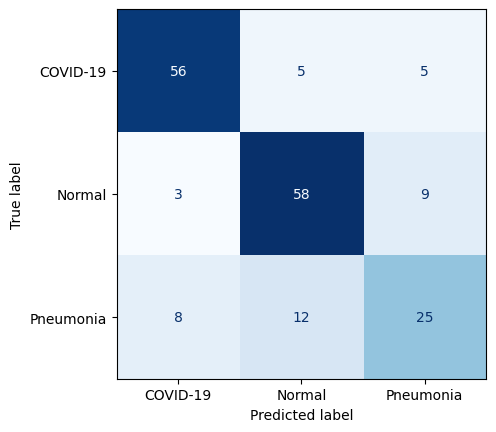

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

In [83]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'max_depth': range(5, 51, 2),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 151, 2)
}

grid_search = GridSearchCV(
    rf, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")


Optimal Hyperparameters:
{'max_depth': 11, 'max_features': 'log2', 'n_estimators': 68}

Optimal F1-macro score:: 0.7815036834473021



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        66
           1       0.76      0.81      0.79        70
           2       0.68      0.60      0.64        45

    accuracy                           0.77       181
   macro avg       0.76      0.75      0.76       181
weighted avg       0.77      0.77      0.77       181


Confusion Matrix:


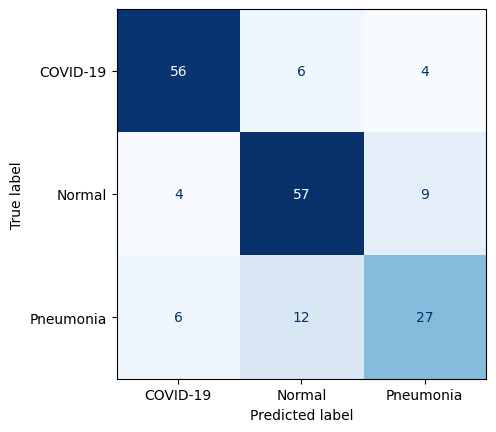

In [84]:
rf = RandomForestClassifier(n_estimators=68, 
                            max_depth=11,
                            max_features='sqrt',
                            random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

SVM


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        66
           1       0.80      0.87      0.84        70
           2       0.73      0.71      0.72        45

    accuracy                           0.80       181
   macro avg       0.79      0.79      0.79       181
weighted avg       0.80      0.80      0.80       181


Confusion Matrix:


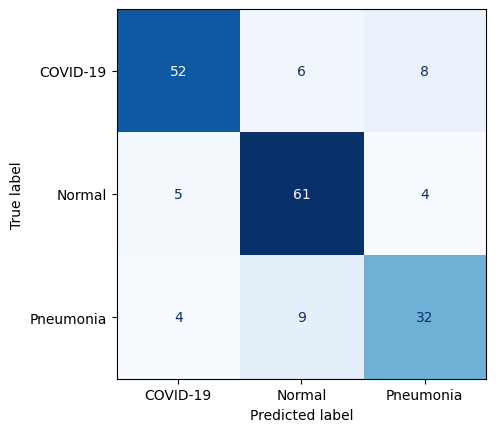

In [85]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=42)

# Train the classifier
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

k-NN


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        66
           1       0.70      0.81      0.75        70
           2       0.56      0.62      0.59        45

    accuracy                           0.70       181
   macro avg       0.70      0.69      0.69       181
weighted avg       0.72      0.70      0.70       181


Confusion Matrix:


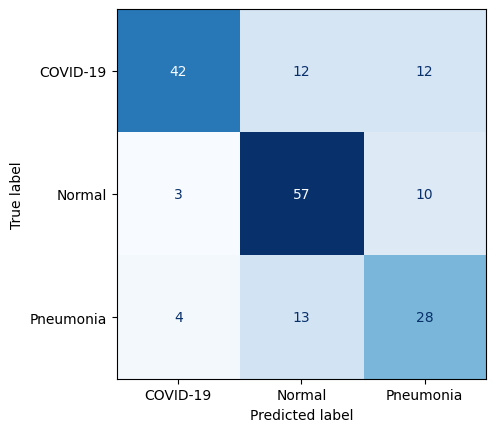

In [86]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)   

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

logistic regression


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77        66
           1       0.78      0.90      0.83        70
           2       0.70      0.71      0.70        45

    accuracy                           0.78       181
   macro avg       0.78      0.77      0.77       181
weighted avg       0.78      0.78      0.78       181


Confusion Matrix:


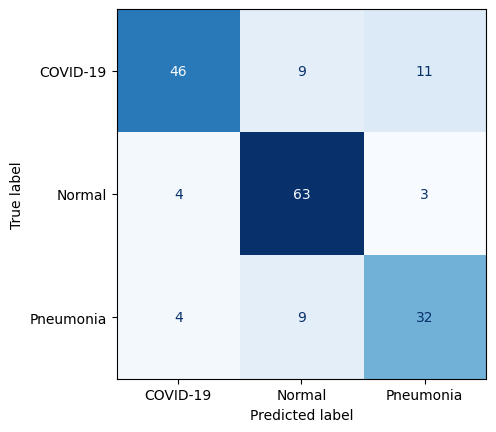

In [87]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()